In [9]:
import yfinance as yf

stock_tickers =['META', 'NFLX', 'TSLA']

database = yf.download(stock_tickers,start='2012-01-01',end ='2021-12-30')
database = database['Adj Close']
data = database.dropna().pct_change(1).dropna()
data

[*********************100%***********************]  3 of 3 completed


Ticker,META,NFLX,TSLA
Date,,,
2012-05-21 00:00:00+00:00,-0.109861,0.025443,0.043904
2012-05-22 00:00:00+00:00,-0.089039,-0.056175,0.070559
2012-05-23 00:00:00+00:00,0.032258,0.062029,0.007143
2012-05-24 00:00:00+00:00,0.032188,-0.022806,-0.023855
2012-05-25 00:00:00+00:00,-0.033909,-0.000711,-0.015522
...,...,...,...
2021-12-22 00:00:00+00:00,-0.011221,0.015407,0.074947
2021-12-23 00:00:00+00:00,0.014495,-0.000244,0.057619
2021-12-27 00:00:00+00:00,0.032633,-0.001580,0.025248


In [10]:
import numpy as np

def MV_Criterion(weight,data):
    Lambda = 3
    W = 1
    Wbar= (1+0.25)/100
    
    portfolio_return = np.multiply(data,np.transpose(weight))
    portfolio_return = portfolio_return.sum(axis=1)
    
    mean = np.mean(portfolio_return,axis=0)
    std = np.std(portfolio_return,axis=0)
    criterion = (Wbar**(-1-Lambda))/1+Lambda +(Wbar**-Lambda)*W*mean - (Wbar**(-1-Lambda))*Lambda*0.5*W**2*std**2
    
    return -1*criterion
    

In [11]:

import numpy as np
from scipy.optimize import Bounds, minimize

validation_score = 0.3
train_size = int(len(data)*(1-validation_score))
train_data = data.iloc[:train_size,:]
test_data = data.iloc[train_size:,:]

n = data.shape[1]
x0 = np.ones(n)

cons = ({'type':'eq','fun':lambda x:np.sum(abs(x))-1})

Bounds = [(0,1) for i in range(0,n)]

res = minimize(MV_Criterion,x0,args=train_data,method="SLSQP",constraints=cons,bounds=Bounds,options={'disp':True})
optimal_weight=res.x
optimal_portfolio_return = np.multiply(test_data,np.transpose(optimal_weight))
optimal_portfolio_return = optimal_portfolio_return.sum(axis=1)

print(optimal_weight)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -40937879.25085531
            Iterations: 7
            Function evaluations: 34
            Gradient evaluations: 7
[0.53111265 0.22995212 0.23893522]


In [12]:
from statistics import covariance
import pandas as pd

def beta_function(portfolio,ben = "^GSPC"):
    benchmarck = yf.download(ben)["Adj Close"]
    benchmarck = benchmarck.dropna().pct_change(1)
    join = pd.concat((portfolio,benchmarck), axis=1).dropna()
    
    cov = np.cov(join,rowvar=False)[0][1]
    var = np.cov(join,rowvar = False)[1][1]
    
    return cov/var


print(beta_function(optimal_portfolio_return,ben="^GSPC"))

[*********************100%***********************]  1 of 1 completed

1.040094174703744


In [13]:
#alpha function
def alpha_function(portfolio,ben = "^GSPC",timeframe = 252):
    benchmarck = yf.download(ben)["Adj Close"]
    benchmarck = benchmarck.dropna().pct_change(1)
    join = pd.concat((portfolio,benchmarck), axis=1).dropna()
    
    beta = beta_function(optimal_portfolio_return,ben=ben)
    mean_stock_return =join.iloc[:,0].mean()*timeframe
    mean_market_return = join.iloc[:,1].mean()*timeframe
    
    alpha = mean_stock_return - beta*mean_market_return
    return alpha
    
print(alpha_function(optimal_portfolio_return,ben = "^GSPC",timeframe = 252))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

0.289146484353486


In [14]:
#Sharpe function

def sharpe_function(portfolio,timeframe = 252):
    mean = portfolio.mean()*timeframe
    std = portfolio.std()*np.sqrt(timeframe)
    return mean/std

print("Sharpe Ratio is"+" ",sharpe_function(optimal_portfolio_return,timeframe=252))

Sharpe Ratio is  1.5256194811558


In [15]:
#Sortino function

def sortino_function(portfolio,timeframe =252):
    mean = portfolio.mean()*timeframe
    std = portfolio[portfolio<0].std()*np.sqrt(timeframe)
    return  mean/std

print("Sortino Ratio is"+" ",sortino_function(optimal_portfolio_return,timeframe=252))

Sortino Ratio is  1.9612851053740823


In [16]:
#Drawdown function
def drawdown_function(portfolio):
    cum_ret =(portfolio+1).cumprod()
    running_max = np.maximum.accumulate((cum_ret.dropna()))
    running_max[running_max<1] = 1
    
    return (cum_ret/running_max)-1


print("drawdown"+" ",drawdown_function(optimal_portfolio_return))

drawdown  Date
2019-02-13 00:00:00+00:00   -0.011149
2019-02-14 00:00:00+00:00   -0.010188
2019-02-15 00:00:00+00:00   -0.013032
2019-02-19 00:00:00+00:00   -0.012213
2019-02-20 00:00:00+00:00   -0.014981
                               ...   
2021-12-22 00:00:00+00:00   -0.069600
2021-12-23 00:00:00+00:00   -0.049680
2021-12-27 00:00:00+00:00   -0.027821
2021-12-28 00:00:00+00:00   -0.029802
2021-12-29 00:00:00+00:00   -0.035231
Length: 726, dtype: float64


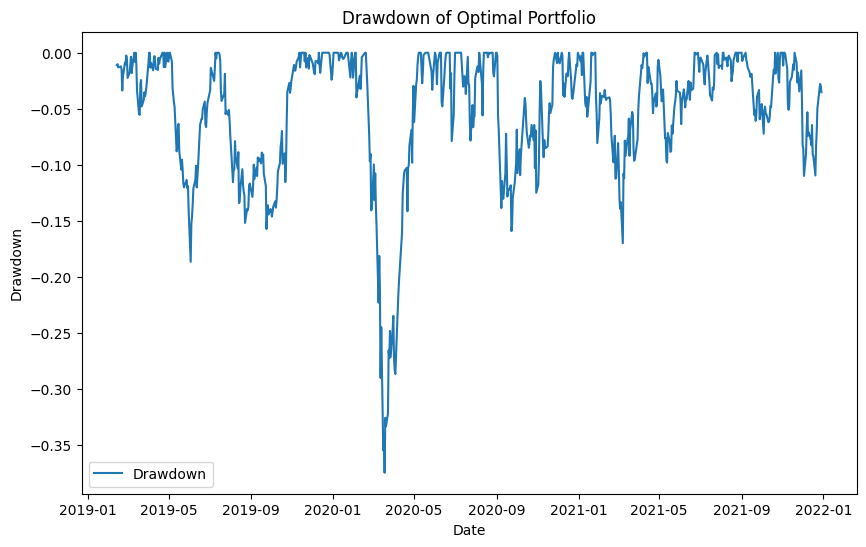

In [17]:
import matplotlib.pyplot as plt

# Calculate drawdown
drawdown = drawdown_function(optimal_portfolio_return)

# Plot drawdown
plt.figure(figsize=(10, 6))
plt.plot(drawdown, label='Drawdown')
plt.title('Drawdown of Optimal Portfolio')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()